In [1]:
%matplotlib inline

### Plot multiple depedent variables grouped by a condition

In [2]:
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
SWEEP_IDS = ['wvq9xpks', 'wu1usmqz']
CONDITION = 'algorithm'
X = 'episode'
YS = ['aux_1_util', 'aux_2_util']
X_LIM = (0, 200)
Y_LIM = (0, 500)
ERROR_BAR = 'se'
SMOOTH = 0

In [4]:
def config_to_algorithm(run_config):
    '''
    Get algorithm name from a run config
    '''
    if run_config['agent'] == 'gentest':
        generator = run_config['agent_args']['generator']
        if generator == "grid_subgoal":
            if run_config['agent_args']['replace_ratio'] == 0:
                return 'random-tasks'
            return 'gen-and-test'
        elif generator == "fourrooms_corner":
            return 'corner'
        elif generator == "fourrooms_hallway":
            return 'hallway'
    return run_config['agent']

In [5]:
def get_datasets(sweep_ids, condition, x, ys):
    '''
    Returns data for all runs assosiated with given sweep ids
    '''
    # Iterate over sweeps
    run_dfs = []
    for sweep_id in sweep_ids:
        sweep_dir = f'../sweep_data/{sweep_id}'
        config_dir = os.path.join(sweep_dir, 'config')
        data_dir = os.path.join(sweep_dir, 'data')
        # Iterate over run configs for the sweep
        for filename in os.listdir(config_dir):
            # Load run config and determine value of condition
            config_path = os.path.join(config_dir, filename)
            with open(config_path, 'r') as file:
                run_config = json.load(file)
            if condition == 'algorithm':
                run_val = config_to_algorithm(run_config)
            else:
                run_val = run_config.get(condition, run_config['agent_args'].get(condition))
            # Load run data
            data_path = os.path.join(data_dir, f'{run_config["run_id"]}.csv')
            run_df = pd.read_csv(data_path, usecols=[x, *ys])
            # make new column for the condition value
            run_df[condition] = run_val
            run_df.dropna(inplace=True)
            run_dfs.append(run_df)
    return run_dfs

In [6]:
def make_plot(sweep_ids, condition, x, ys, x_lim, y_lim, smooth, errorbar='ci'):
    '''
    Plots
    '''
    run_dfs = get_datasets(sweep_ids, condition, x, ys)
    # Compute running average of y values for each run 
    if smooth > 1:
        for df in run_dfs:
            for y in ys:
                df[y] = df[y].rolling(window=smooth, min_periods=1, center=True).mean()
    stacked_df = pd.concat(run_dfs, axis=0, ignore_index=True)
    stacked_df = pd.melt(stacked_df, id_vars=[x, condition], var_name='variable', value_name='value')
    # Plot learning curves for each level of the condition, averaging y values for each timestep across runs with the same level
    sns.set_theme(style="darkgrid", font_scale=1.5, rc={"figure.dpi":300, 'savefig.dpi':300})
    sns.lineplot(x=x, y='value', hue=condition, style='variable', data=stacked_df, errorbar=errorbar)
    plt.xlim(*x_lim)
    plt.ylim(*y_lim)
    plt.legend(loc='upper right', fontsize=8).set_draggable(True)
    # Set x-axis scale in scientific notation if max x is large
    xscale = np.max(np.asarray(stacked_df[x])) > 5e3
    if xscale:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout(pad=0.5)
    plt.show()

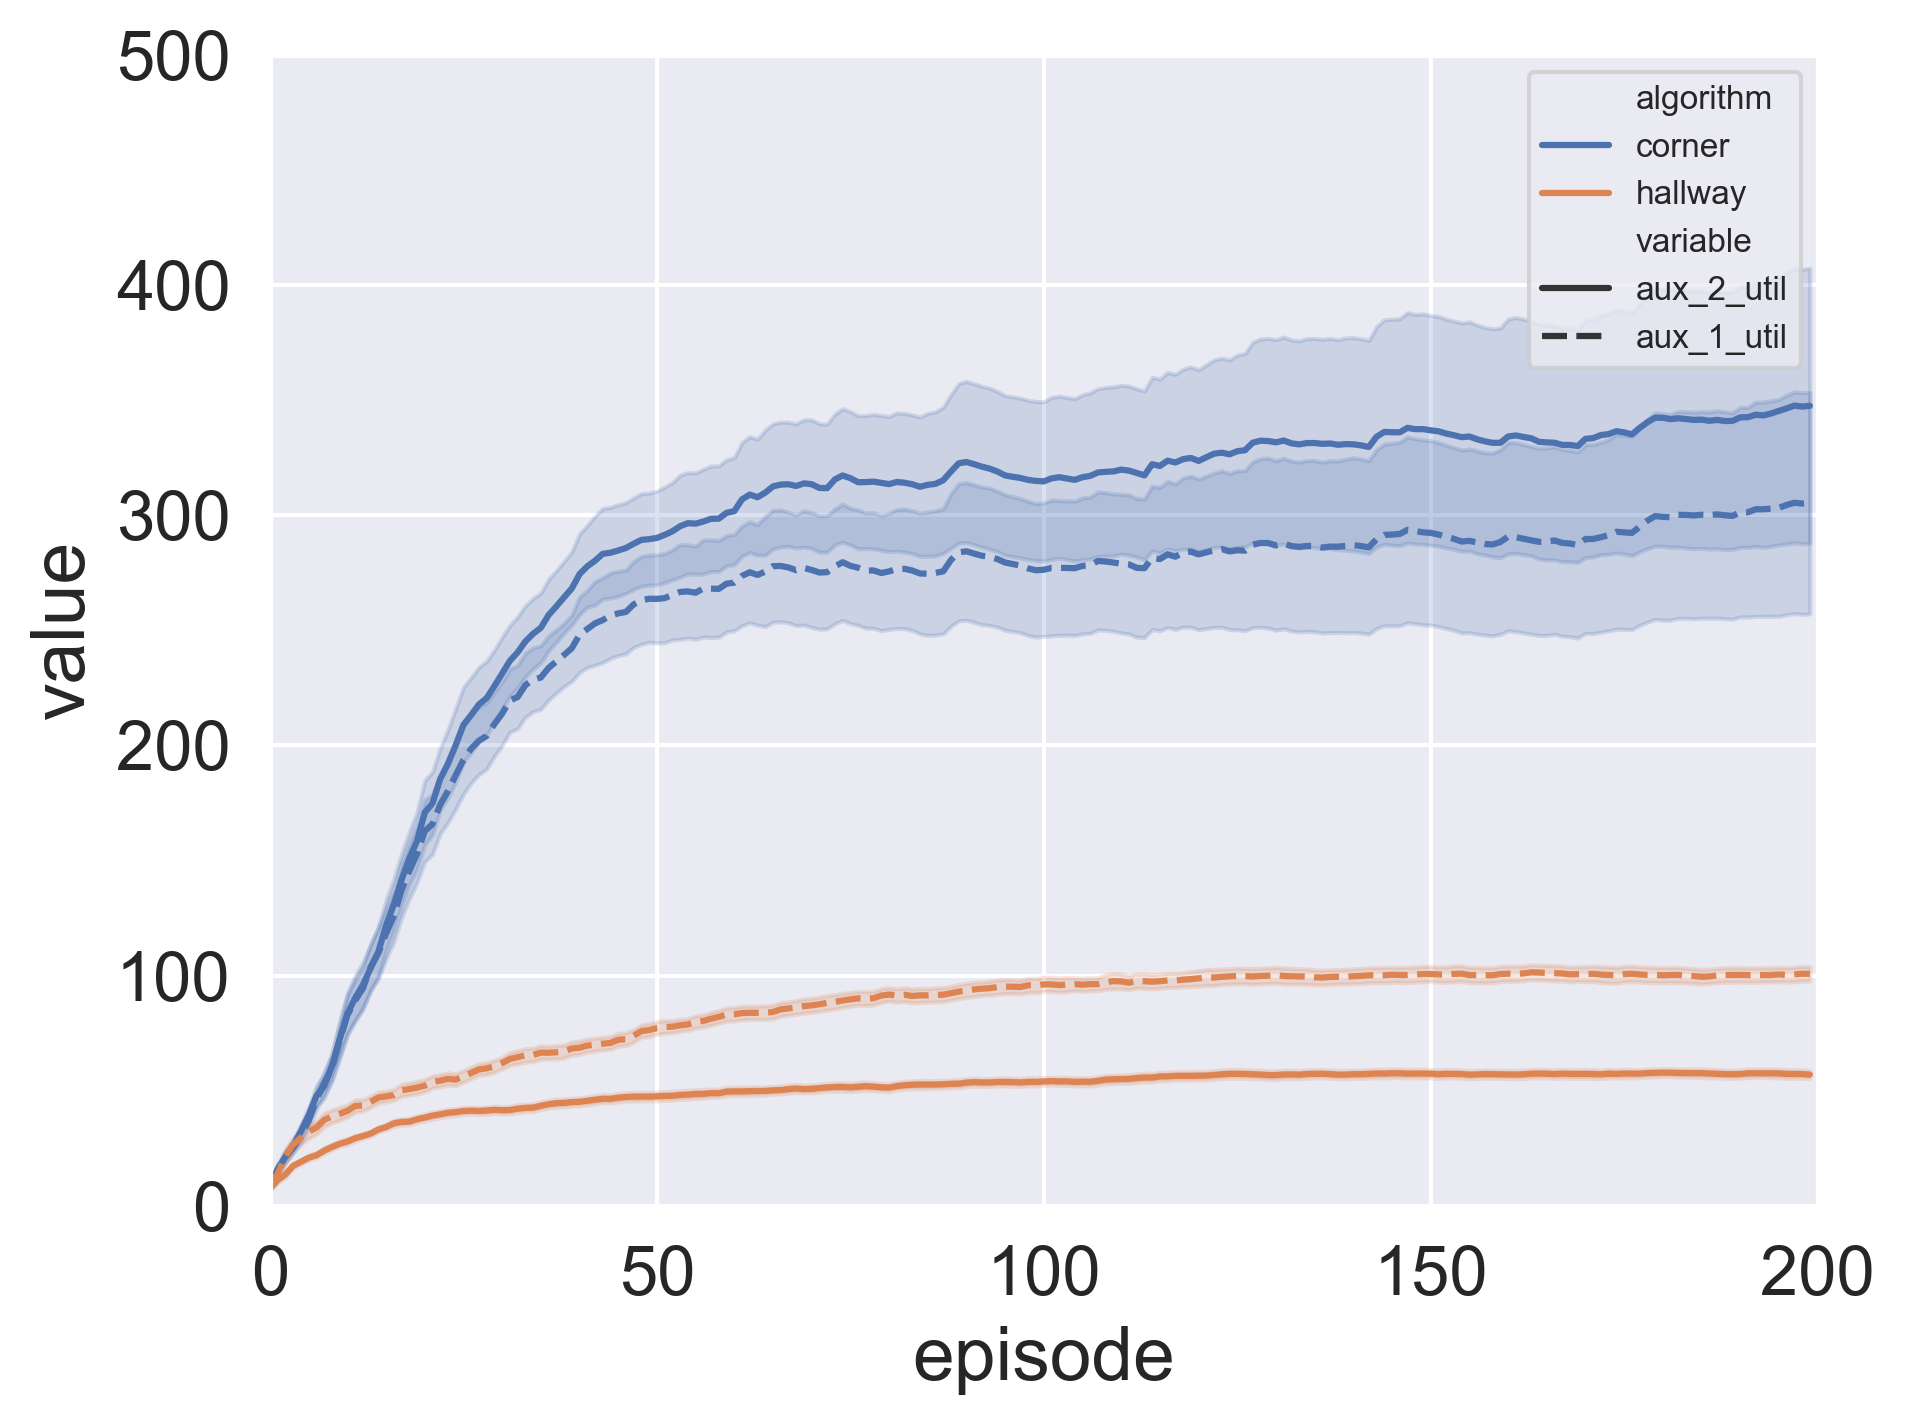

In [7]:
make_plot(SWEEP_IDS, CONDITION, X, YS, X_LIM, Y_LIM, SMOOTH, ERROR_BAR)

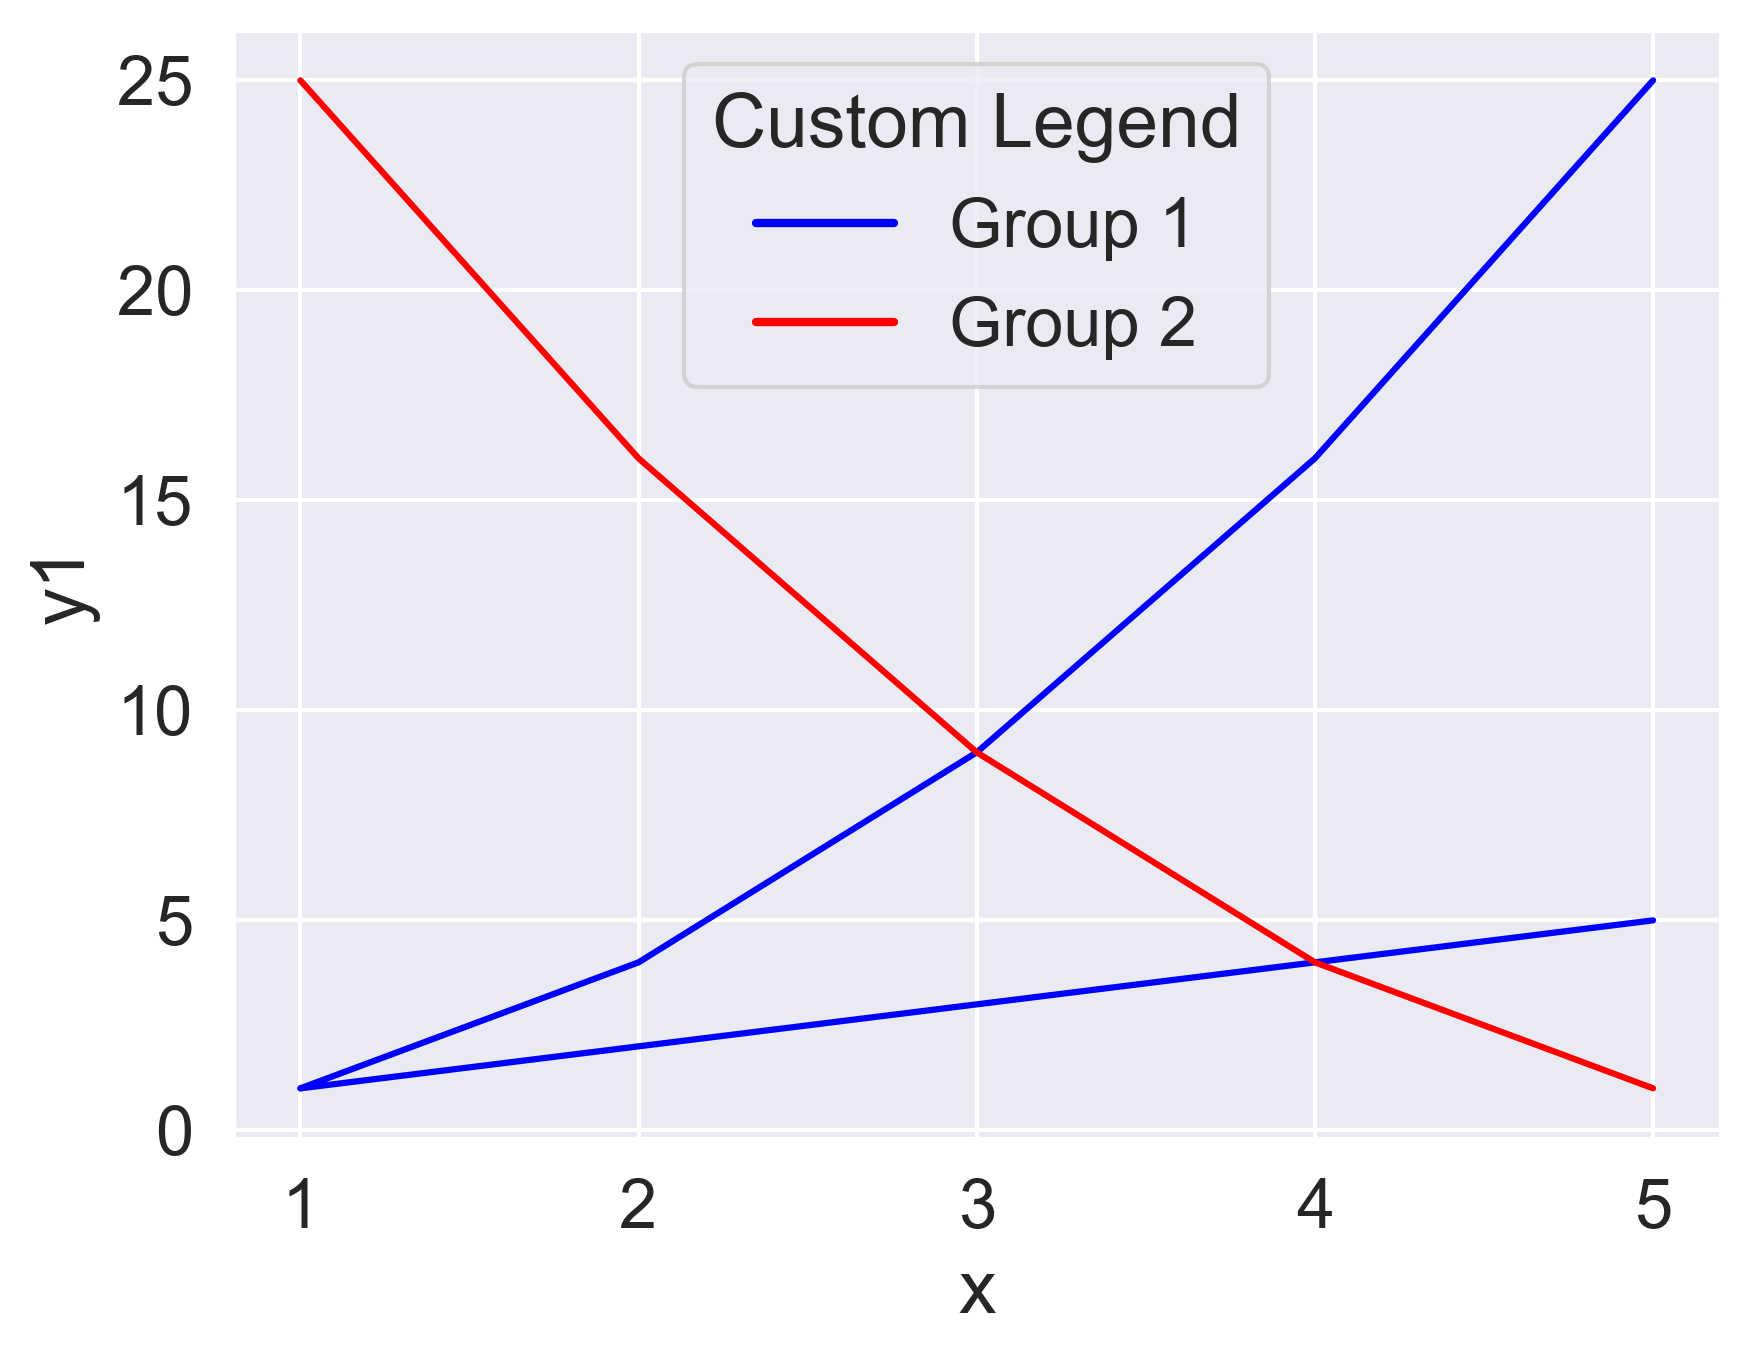

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = {
    'x': [1, 2, 3, 4, 5],
    'y1': [1, 4, 9, 16, 25],
    'y2': [1, 2, 3, 4, 5],
    'y3': [25, 16, 9, 4, 1]
}

df = pd.DataFrame(data)

# Plot each line separately with the same style but different colors
sns.lineplot(data=df, x='x', y='y1', color='blue')
sns.lineplot(data=df, x='x', y='y2', color='blue')
sns.lineplot(data=df, x='x', y='y3', color='red')

# Custom legend
custom_lines = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Group 1'),
    plt.Line2D([0], [0], color='red', lw=2, label='Group 2')
]

plt.legend(handles=custom_lines, title="Custom Legend")
plt.show()